# High SNR Fiber Views

Quickly spin through the spectroscopic pipeline output for one exposure and plot fibers above some threshold SNR. Needed:
- A date (YYYYMMDD)
- An exposure ID (000nnnnn)

In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

from glob import glob

import desispec.io
from desispec.specscore import compute_frame_scores
from desimodel.focalplane.geometry import FocalPlane

# Shut up about figure limits.
mpl.rcParams['figure.max_open_warning'] = 0

## Access and Plotting Functions

Grab sframes, compute SNR with `desispec.specscore`, and look for SNR above threshold in at least 2 out of 3 cameras. Plot the high-SNR fibers and their spectra.

In [7]:
def get_exposure_snr(date, expid, verbose=False):
    """Grab sframes for a given expid and compute SNRs.
    Assume running on NERSC.
    
    Parameters
    ----------
    date : int
        YYYYMMDD
    expid : int
        nnnnn
    verbose : bool
        Print a bit of extra info about the sframes globbed at NERSC.
    
    Returns
    -------
    data : astropy.Table
        Table of fibers with computed SNRs.
    """
    sframes = glob('/global/project/projectdirs/desi/spectro/redux/daily/exposures/{}/{:08d}/sframe-*.fits'.format(date, expid))

    x, y, fib, pet, snr, cam, wav, flux = [], [], [], [], [], [], [], []
    
    for specfile in sframes:
        if 'sframe-z' in specfile:
            _cam = 'Z'
        elif 'sframe-r' in specfile:
            _cam = 'R'
        else:
            _cam = 'B'
            
        if verbose:
            print(specfile)
        
        sframe = desispec.io.read_frame(specfile)
        _x, _y = [sframe.fibermap['FIBERASSIGN_{}'.format(_)] for _ in 'XY']
        scores, comments = compute_frame_scores(sframe)
        x += list(_x)
        y += list(_y)
        fib += list(sframe.fibermap['FIBER'])
        pet += list(sframe.fibermap['PETAL_LOC'])
        _snr = scores['MEDIAN_SNR_{}'.format(_cam)]
        snr += list(_snr)
        cam += len(_x) * [_cam]

    t = Table()
    t['FIBER'] = fib
    t['PETAL'] = pet
    t['FIBERASSIGN_X'] = x
    t['FIBERASSIGN_Y'] = y
    t['MEDIAN_CALIB_SNR'] = snr
    t['CAM'] = cam
    t.meta['EXPID'] = expid
    t.meta['DATE'] = date
    return t

def plot_lit_fibers(data, minsnr=1.):
    """A Nightwatch-like plot of SNR in fibers.
    
    Parameters
    ----------
    data : astropy.Table
        Table of SNRs obtained from get_exposure_snr.
    minsnr : float
        SNR threshold.
    
    Returns
    -------
    ntargets : int
        number of fibers with SNR above threshold.
    fig : matplotlib.Figure
        Plot object for manipulation/output.
    """
    expid = data.meta['EXPID']
    date = data.meta['DATE']
    
    x, y = [data['FIBERASSIGN_{}'.format(_)] for _ in 'XY']
    snr = data['MEDIAN_CALIB_SNR']
    cam = data['CAM']
    
    highsnr = data['MEDIAN_CALIB_SNR'] > minsnr
    bcam = (data['CAM'] == 'B') | (data['CAM'] == b'B')
    rcam = (data['CAM'] == 'R') | (data['CAM'] == b'R')
    zcam = (data['CAM'] == 'Z') | (data['CAM'] == b'Z')

    fibers = (set(data['FIBER'][highsnr & bcam]) & set(data['FIBER'][highsnr & zcam])) | \
             (set(data['FIBER'][highsnr & bcam]) & set(data['FIBER'][highsnr & rcam])) | \
             (set(data['FIBER'][highsnr & rcam]) & set(data['FIBER'][highsnr & zcam]))
    fibers = np.array(sorted(fibers))
    ntargets = len(fibers)
    
    fig, axes = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
    
    for c, f, ax in zip([bcam, rcam, zcam], 'BRZ', axes):
        mask = np.in1d(data[c]['FIBER'], fibers)
        ax.plot(x, y, 'k,', alpha=0.1)
        
        r_fp = 420.
        phi = np.linspace(0., 2*np.pi, 201)
        x_fp = r_fp*np.cos(phi)
        y_fp = r_fp*np.sin(phi)
        ax.plot(x_fp, y_fp, 'k', lw=1)
        
        sc = ax.scatter(x[c][mask], y[c][mask], s=snr[c][mask],
                        c=snr[c][mask], cmap='coolwarm', vmin=minsnr, vmax=30)
        
#         if c is rcam:
        cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, orientation='horizontal')
        cb.set_label('MEDIAN_CALIB_SNR')
        ax.text(330,370, '{}'.format(expid))
        ax.set(aspect='equal',
               xlim=(-r_fp, r_fp),
               ylim=(-r_fp, r_fp),
               title='{}'.format(f))
        ax.set_axis_off()
        
    fig.tight_layout()
    return ntargets, fig

def plot_lit_spectra(data, minsnr=1.):
    """Loop through high-SNR fibers and plot redux spectra.
    
    Parameters
    ----------
    data : astropy.Table
        Table of SNRs obtained from get_exposure_snr.
    minsnr : float
        SNR threshold.
    """
    expid = data.meta['EXPID']
    date = data.meta['DATE']
    
    snr = data['MEDIAN_CALIB_SNR']
    cam = data['CAM']
    
    highsnr = data['MEDIAN_CALIB_SNR'] > minsnr
    bcam = (data['CAM'] == 'B') | (data['CAM'] == b'B')
    rcam = (data['CAM'] == 'R') | (data['CAM'] == b'R')
    zcam = (data['CAM'] == 'Z') | (data['CAM'] == b'Z')

    fibers = (set(data['FIBER'][highsnr & bcam]) & set(data['FIBER'][highsnr & zcam])) | \
             (set(data['FIBER'][highsnr & bcam]) & set(data['FIBER'][highsnr & rcam])) | \
             (set(data['FIBER'][highsnr & rcam]) & set(data['FIBER'][highsnr & zcam]))
    fibers = np.array(sorted(fibers))
    ntargets = len(fibers)
    petals = np.unique(data['PETAL'])
    
    bspec, rspec, zspec = {}, {}, {}
    
    spath = '/global/project/projectdirs/desi/spectro/redux/daily/exposures'
    sdir = '{}/{:08d}'.format(date, expid)
    
    for petal in petals:
        bfile, rfile, zfile = ['sframe-{}{}-{:08d}.fits'.format(cam, petal, expid) for cam in 'brz']
        bfile, rfile, zfile = ['/'.join([spath, sdir, _]) for _ in [bfile, rfile, zfile]]
        bframe, rframe, zframe = [desispec.io.read_frame(_) for _ in [bfile, rfile, zfile]]
        
        pc = np.logical_and(data['PETAL']==petal, data['CAM']=='B')
        mask = np.in1d(data[pc]['FIBER'], fibers)
        idx = np.flatnonzero(mask)
        
        for i in idx:
            fig, ax = plt.subplots(1,1, figsize=(9,4), tight_layout=True)
            
            fiber_id = data[pc]['FIBER'][i]
            
            for frame, col in zip([bframe, rframe, zframe], ['royalblue', 'red', 'brown']):
                ax.plot(frame[i].wave, frame[i].flux, color=col, alpha=0.7)
                
            ax.set(title='Exposure {}, Fiber {}'.format(expid, fiber_id),
                   xlabel=r'wavelength [$\AA$]',
                   ylabel=r'count $\AA^{-1}$')
            
#             fig.savefig('spectra/{:08d}/spec-{:08d}-{:04d}.png'.format(expid, expid, fiber_id),
#                         dpi=100)

## Enter Data Here

In [10]:
data = get_exposure_snr(20200123, 43528, verbose=True)

/global/project/projectdirs/desi/spectro/redux/daily/exposures/20200123/00043528/sframe-z0-00043528.fits
/global/project/projectdirs/desi/spectro/redux/daily/exposures/20200123/00043528/sframe-r8-00043528.fits
/global/project/projectdirs/desi/spectro/redux/daily/exposures/20200123/00043528/sframe-z3-00043528.fits
/global/project/projectdirs/desi/spectro/redux/daily/exposures/20200123/00043528/sframe-z2-00043528.fits
/global/project/projectdirs/desi/spectro/redux/daily/exposures/20200123/00043528/sframe-b4-00043528.fits
/global/project/projectdirs/desi/spectro/redux/daily/exposures/20200123/00043528/sframe-r6-00043528.fits
/global/project/projectdirs/desi/spectro/redux/daily/exposures/20200123/00043528/sframe-r3-00043528.fits
/global/project/projectdirs/desi/spectro/redux/daily/exposures/20200123/00043528/sframe-z7-00043528.fits
/global/project/projectdirs/desi/spectro/redux/daily/exposures/20200123/00043528/sframe-b7-00043528.fits
/global/project/projectdirs/desi/spectro/redux/daily/ex

110


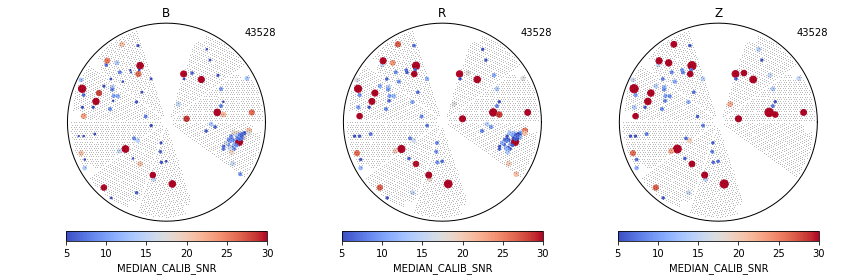

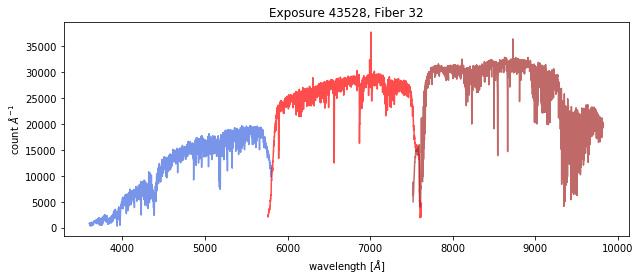

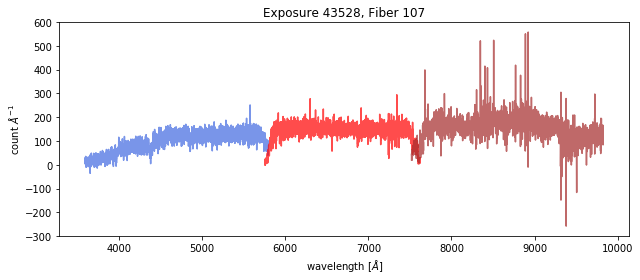

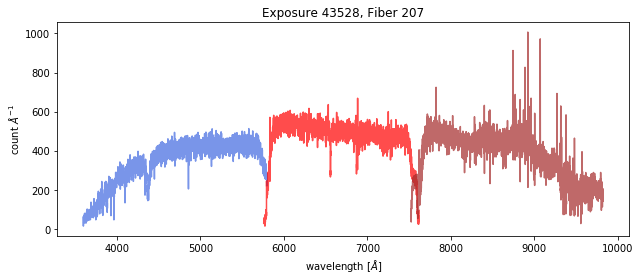

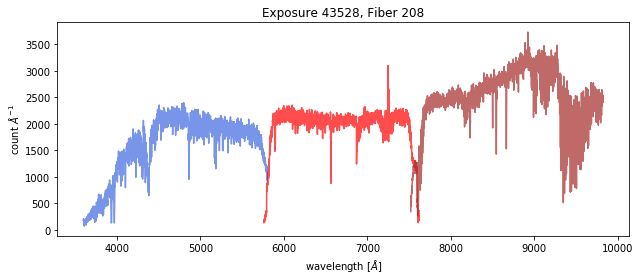

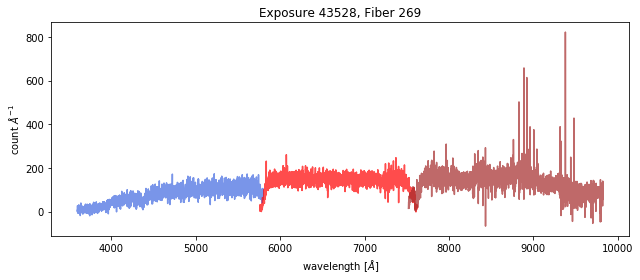

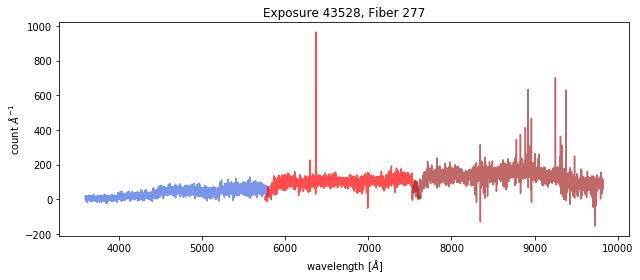

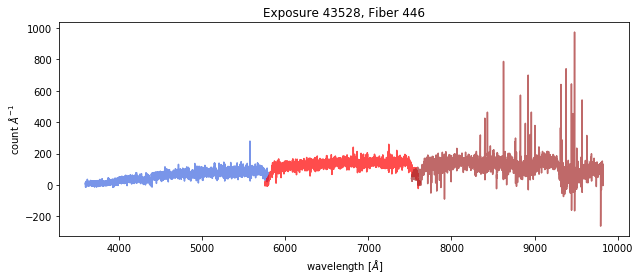

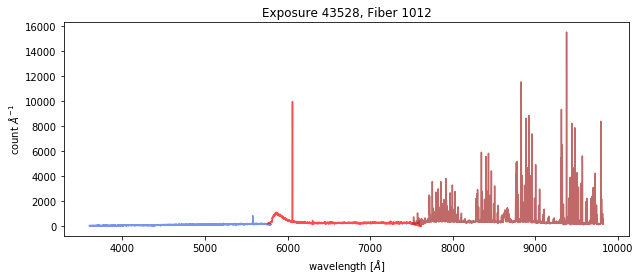

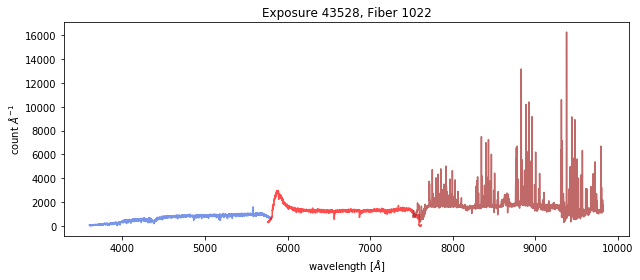

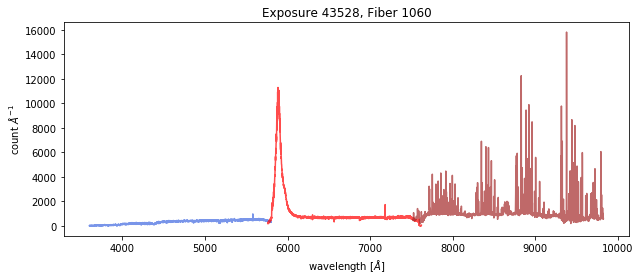

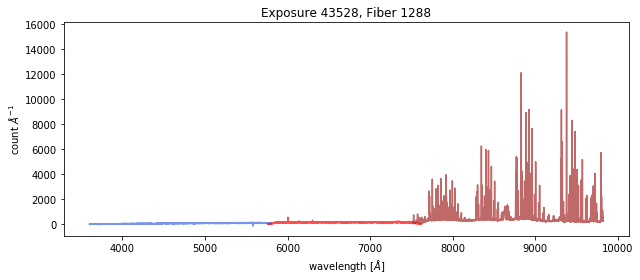

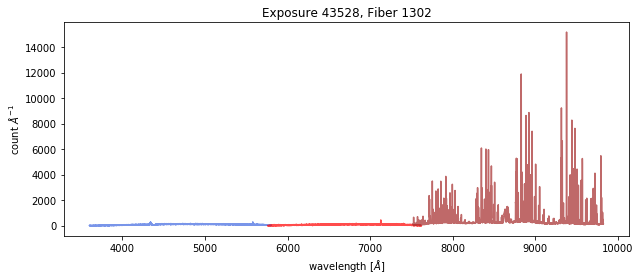

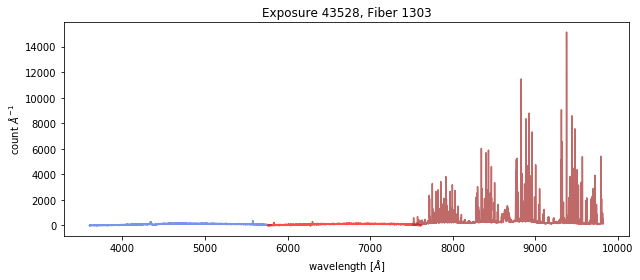

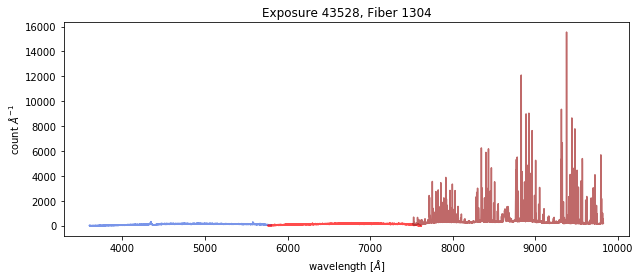

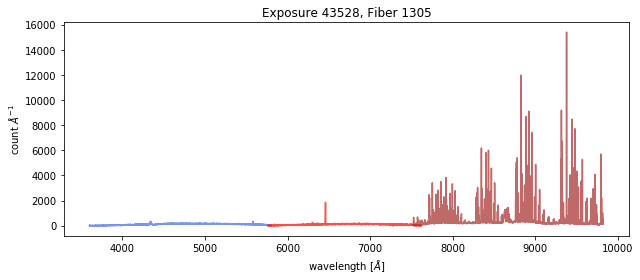

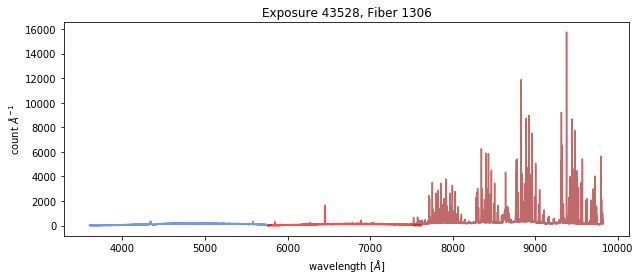

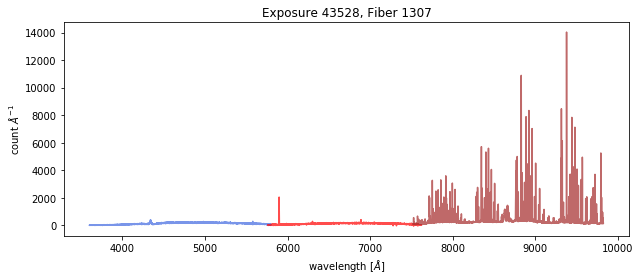

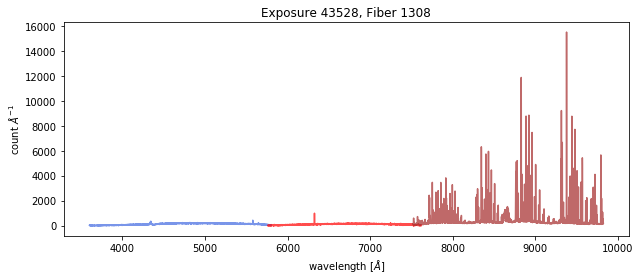

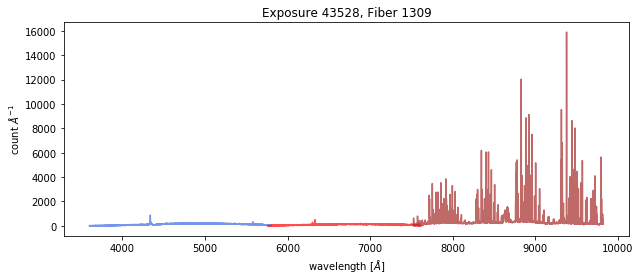

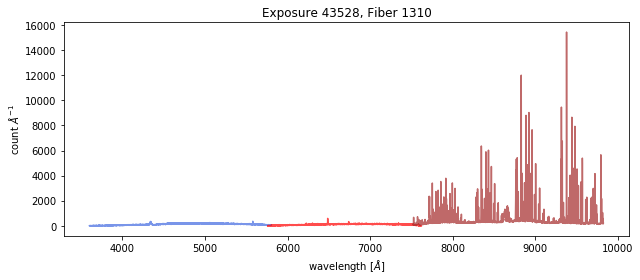

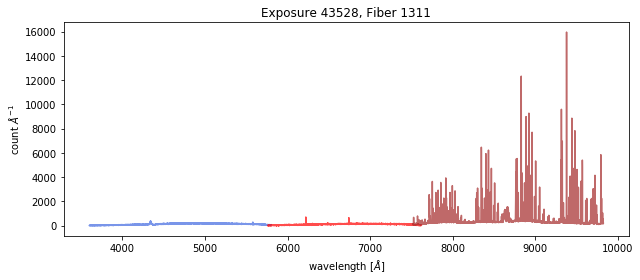

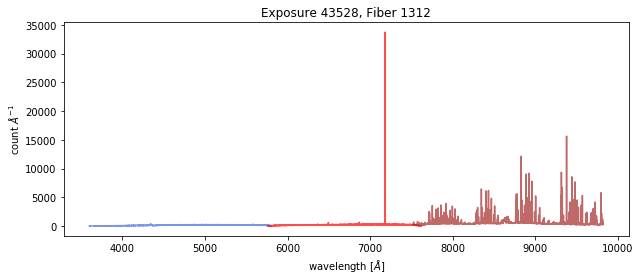

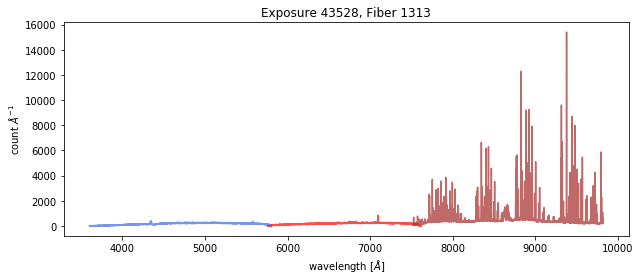

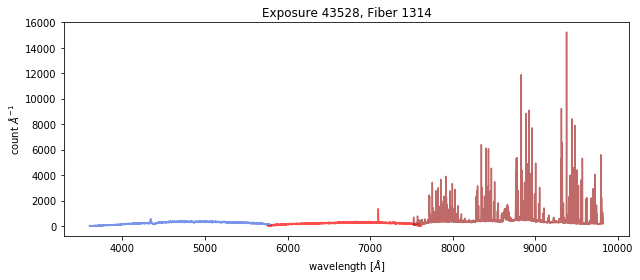

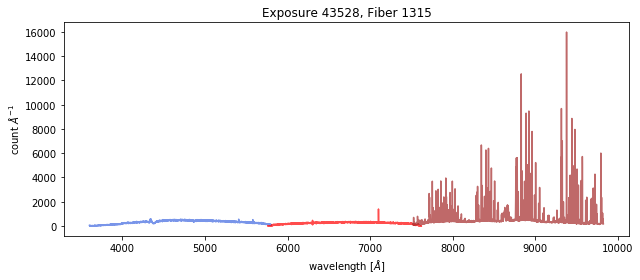

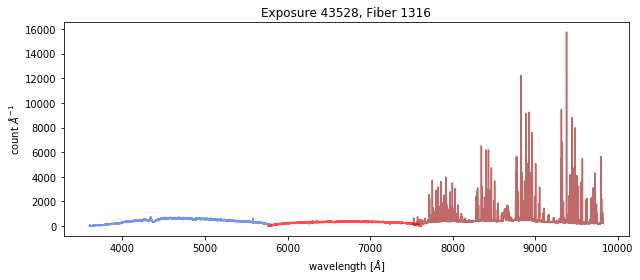

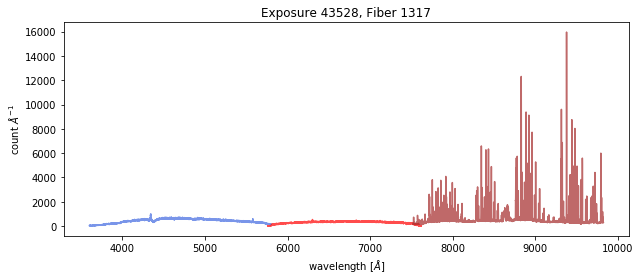

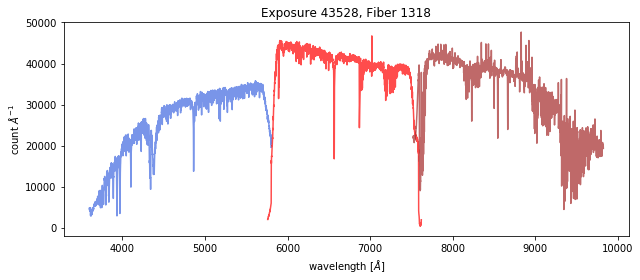

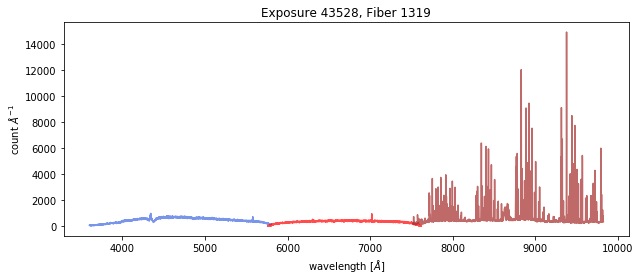

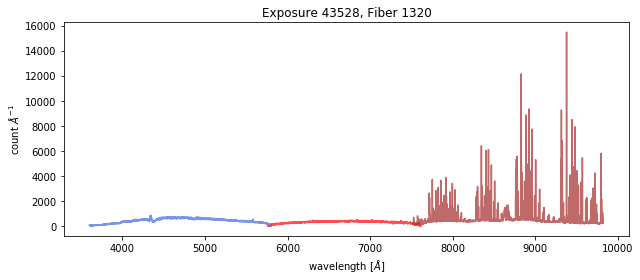

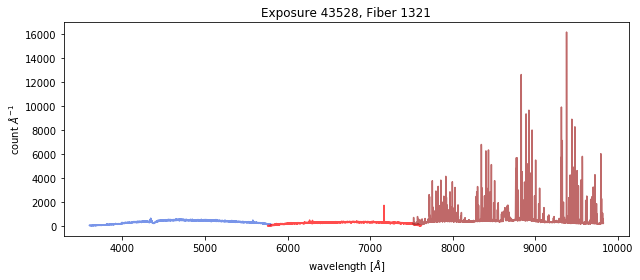

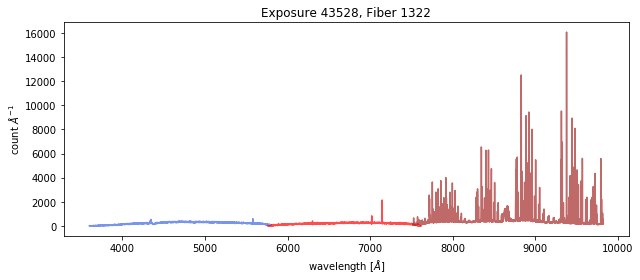

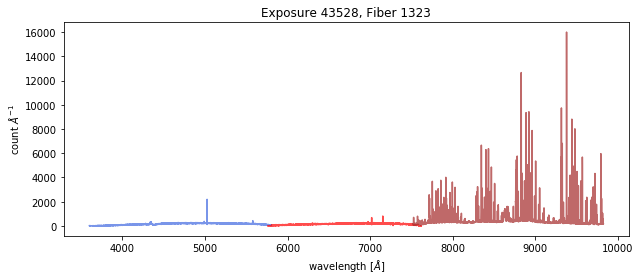

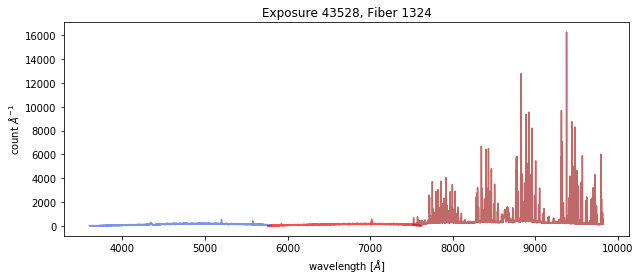

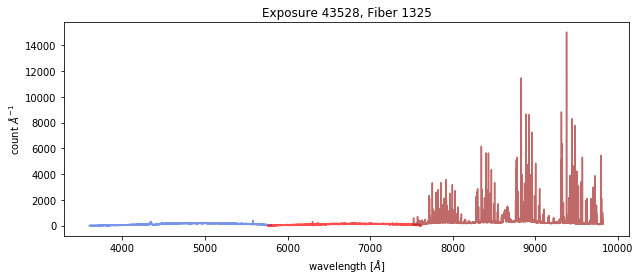

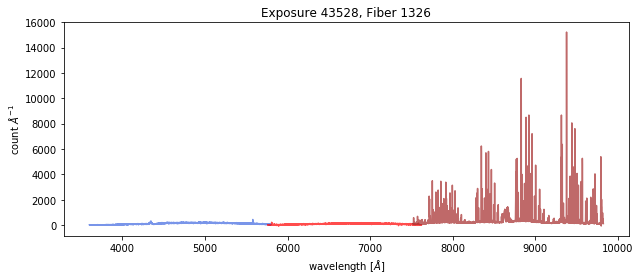

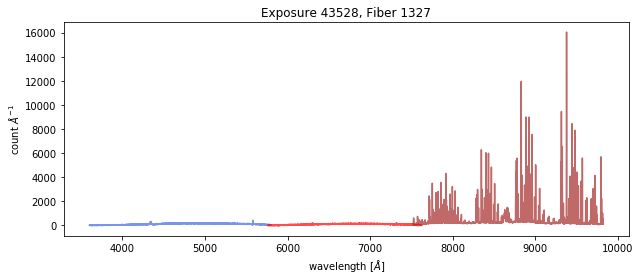

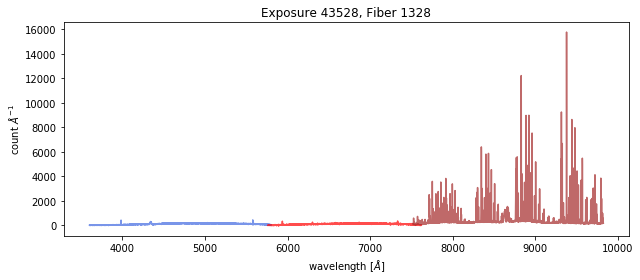

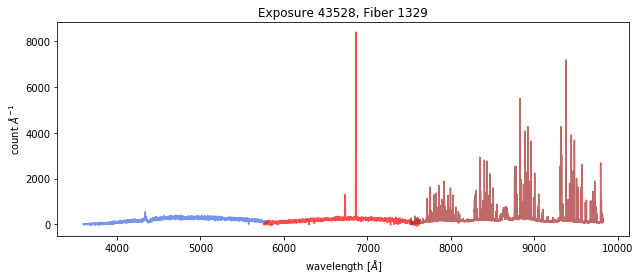

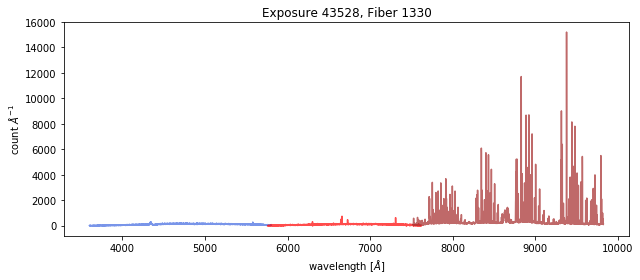

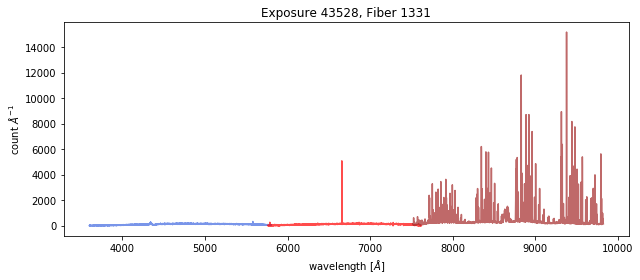

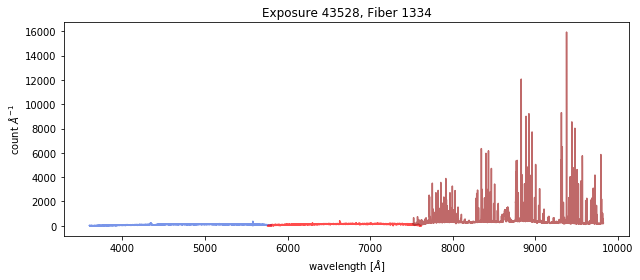

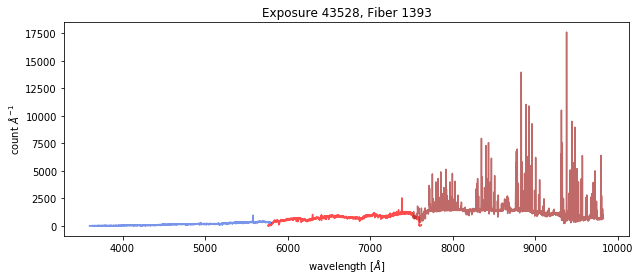

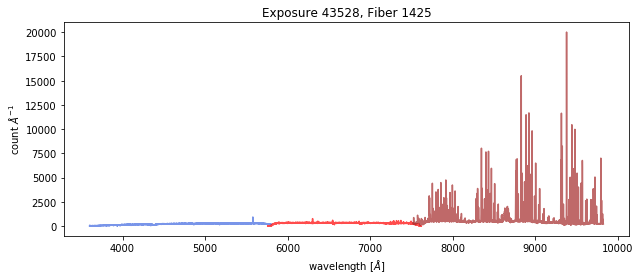

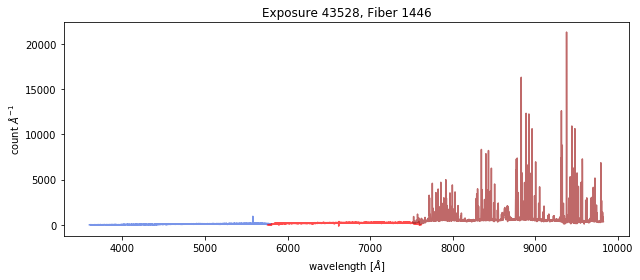

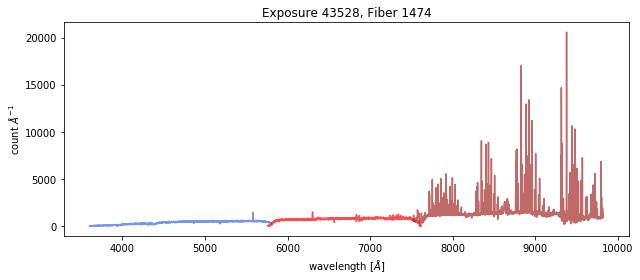

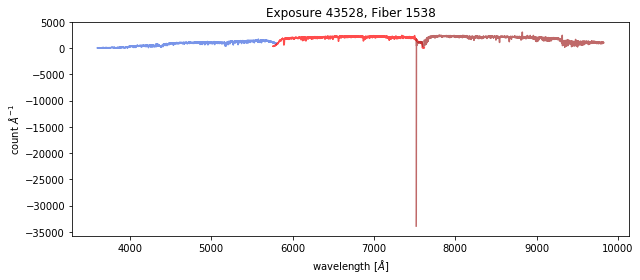

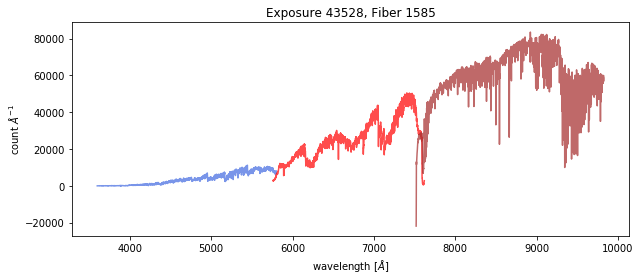

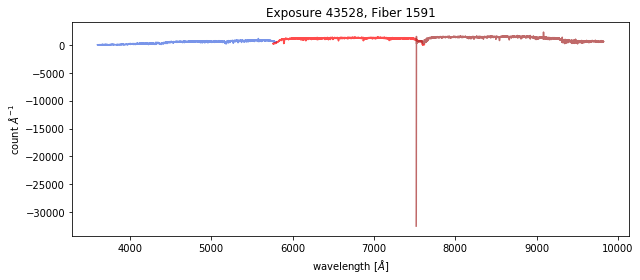

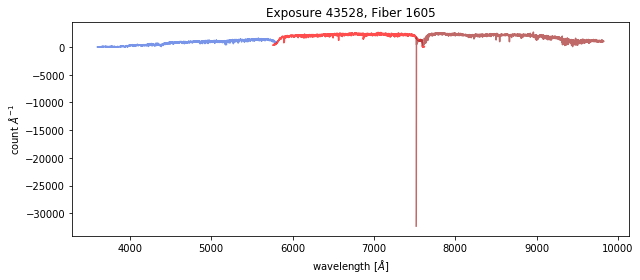

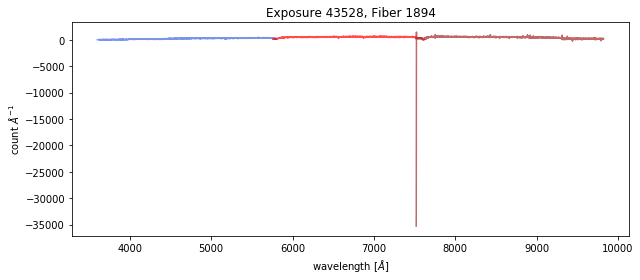

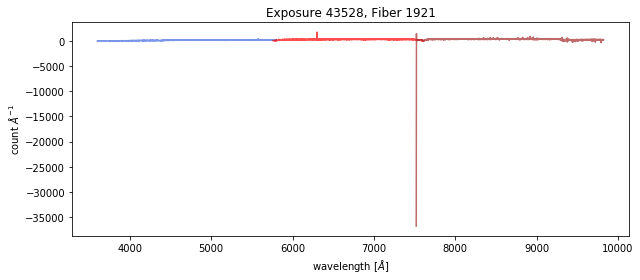

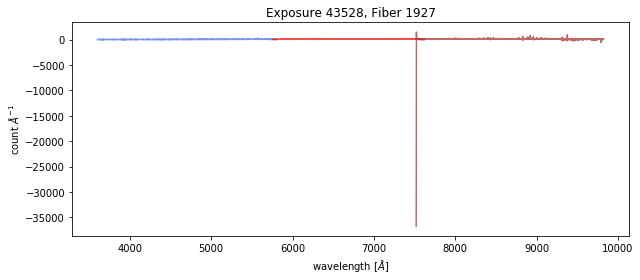

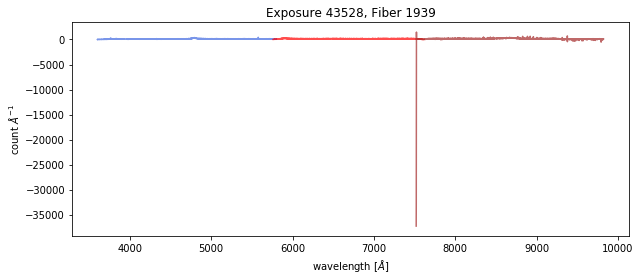

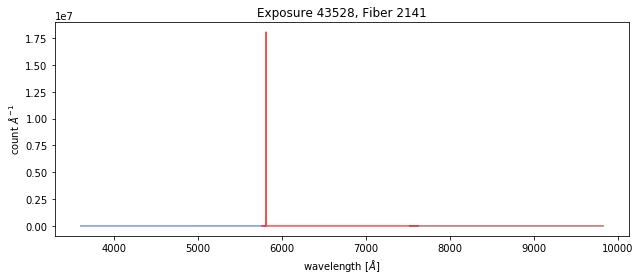

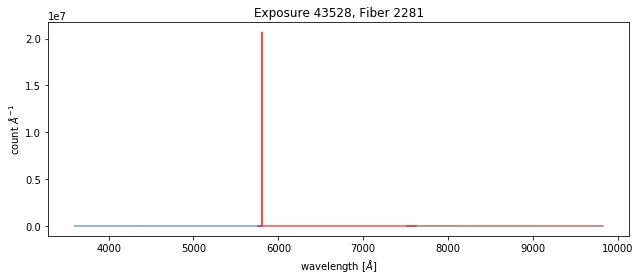

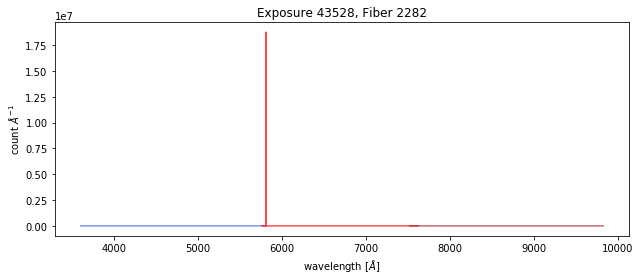

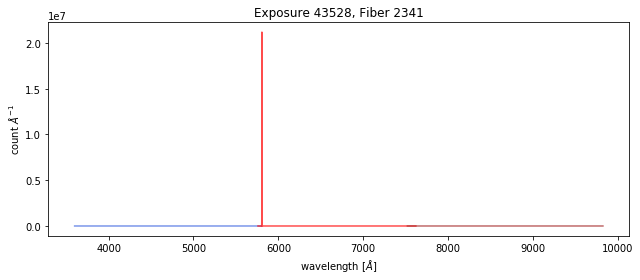

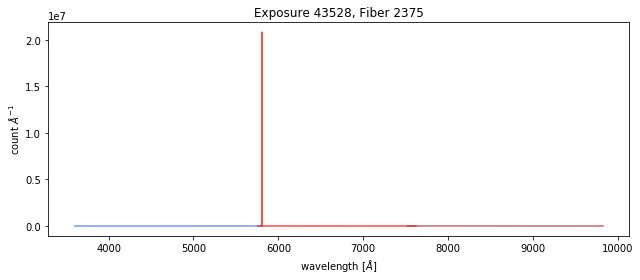

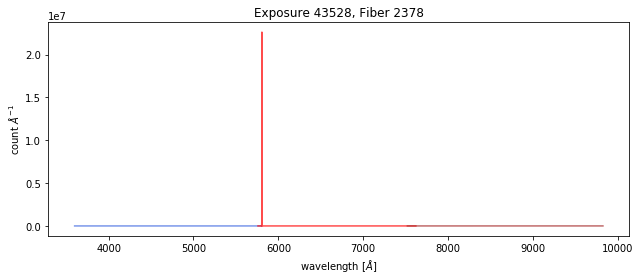

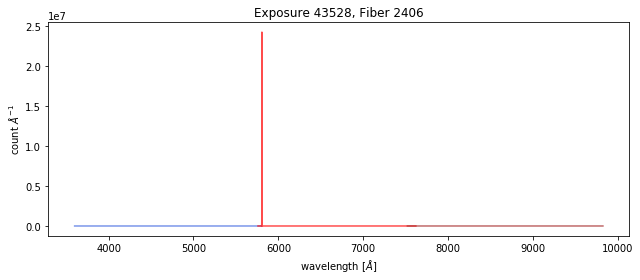

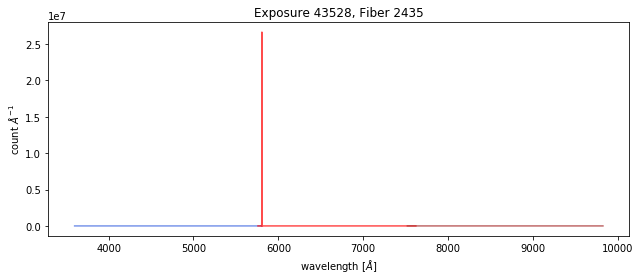

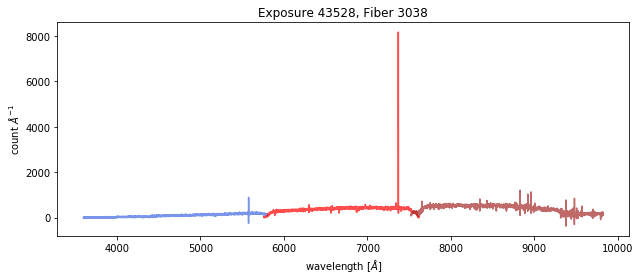

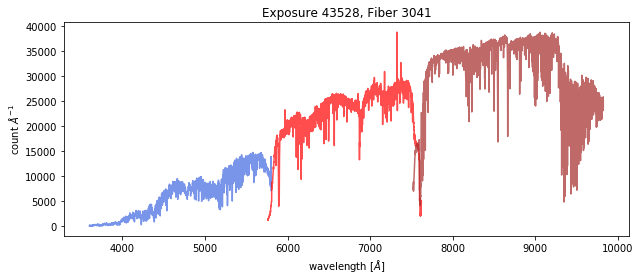

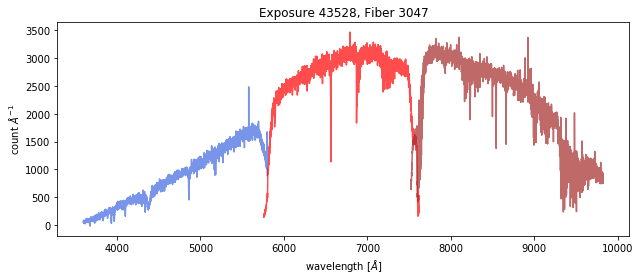

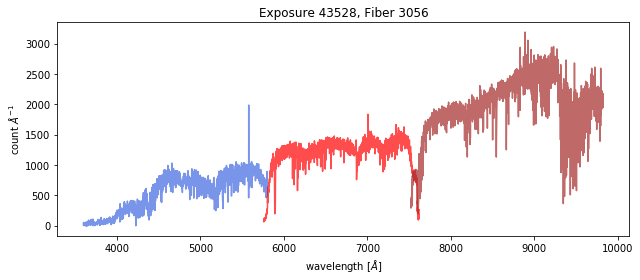

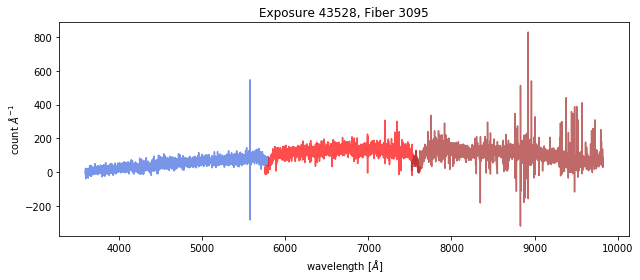

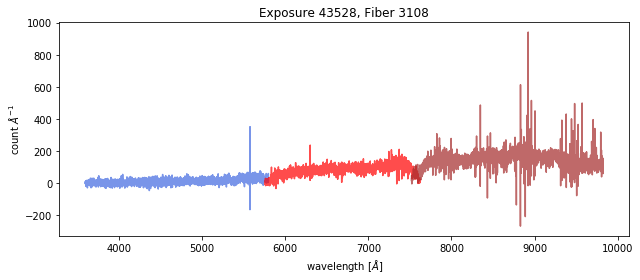

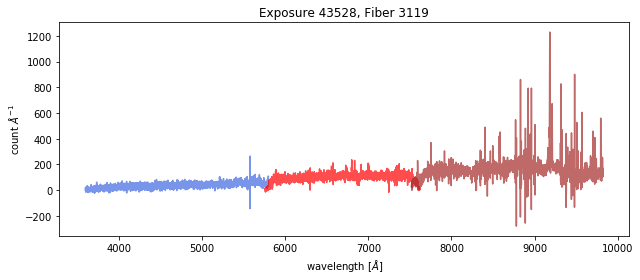

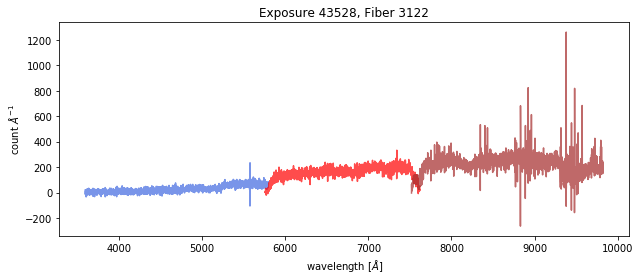

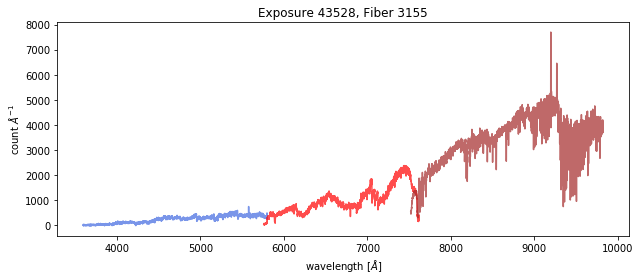

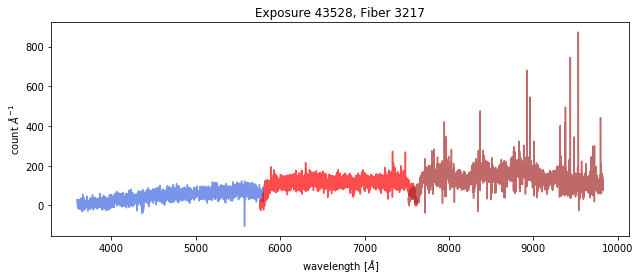

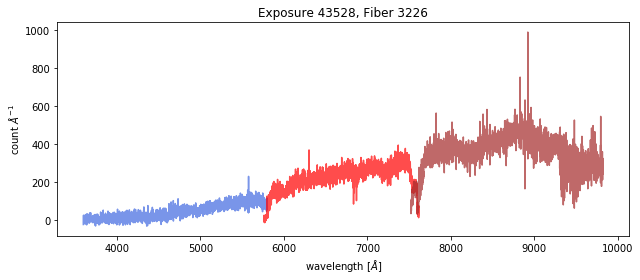

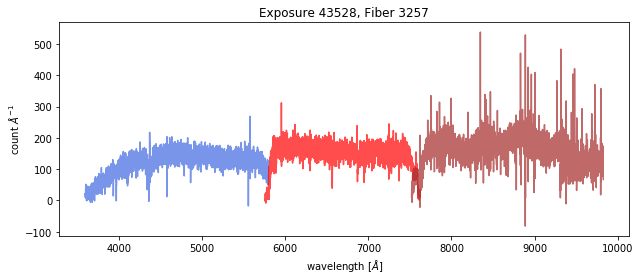

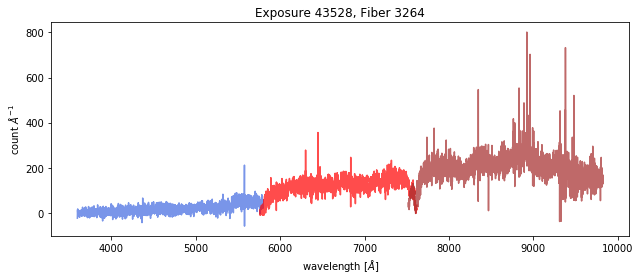

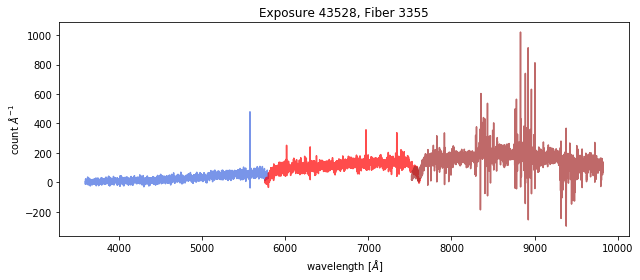

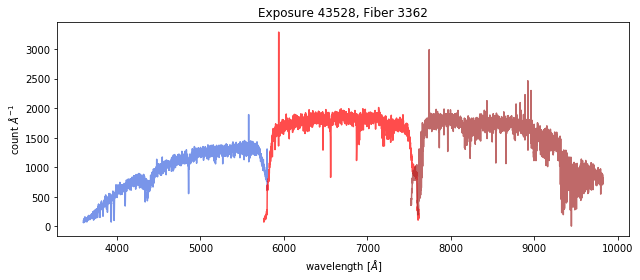

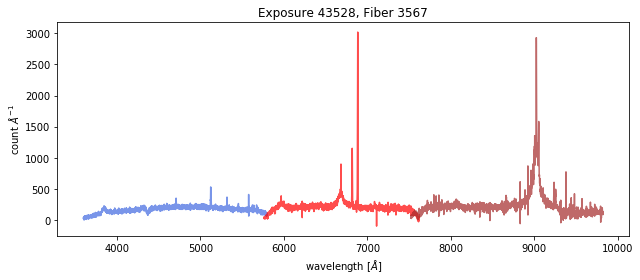

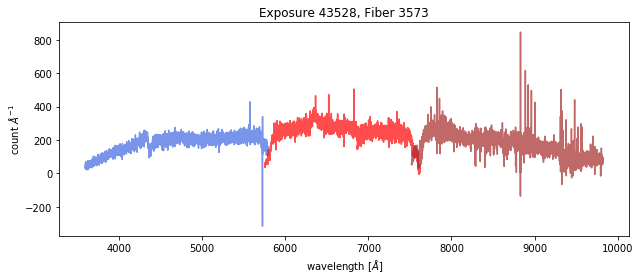

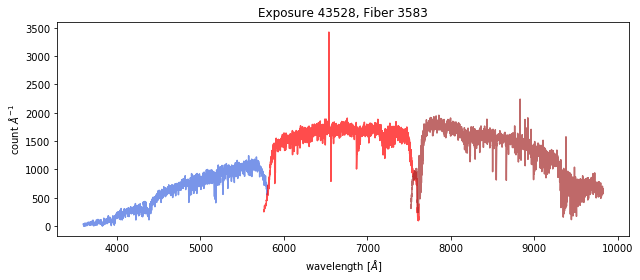

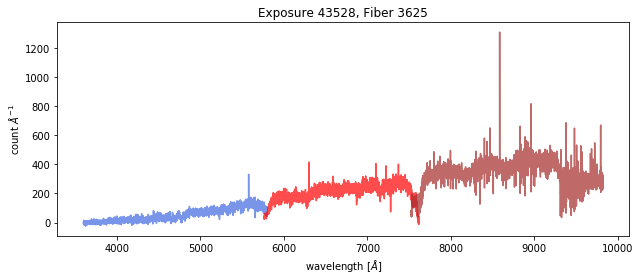

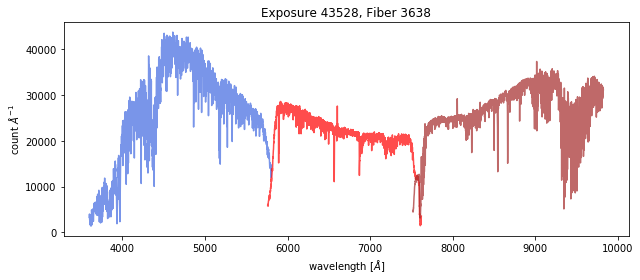

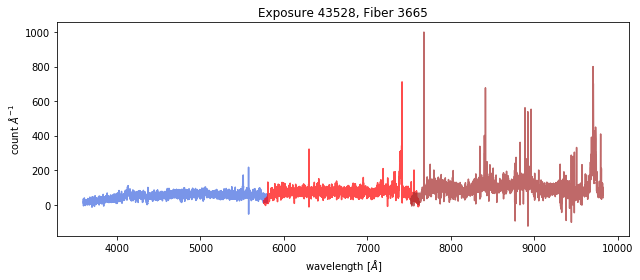

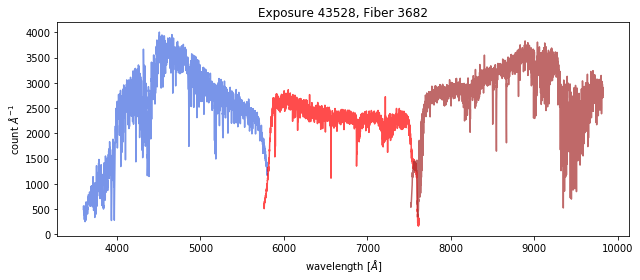

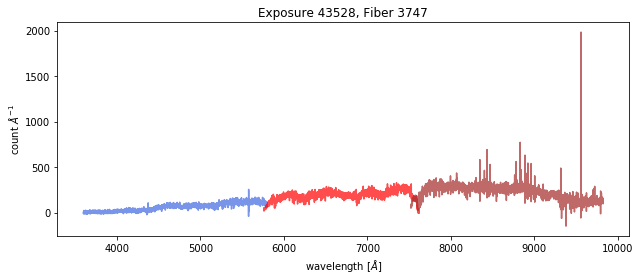

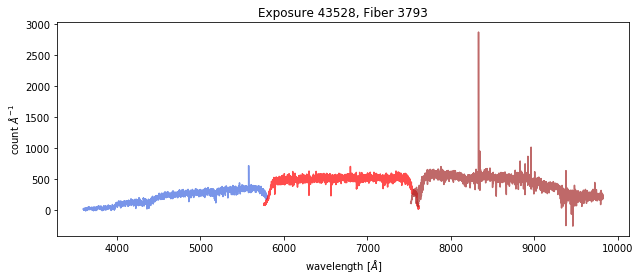

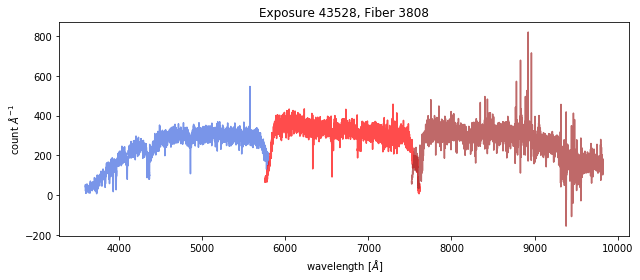

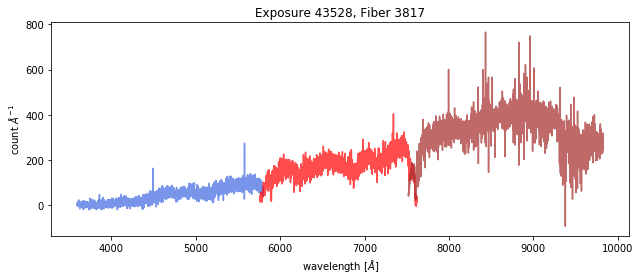

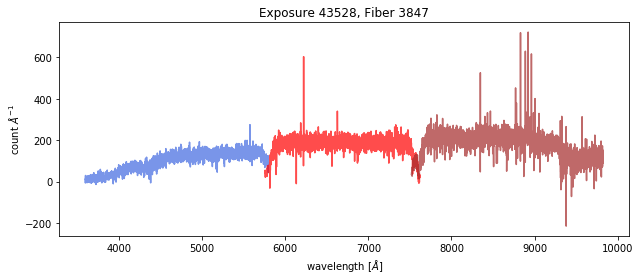

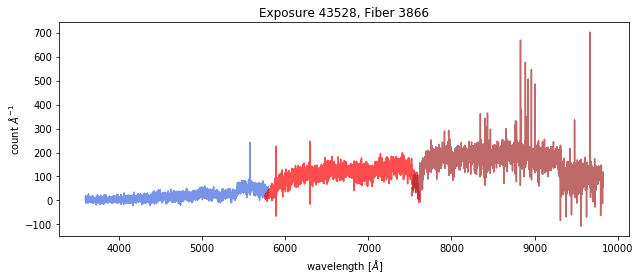

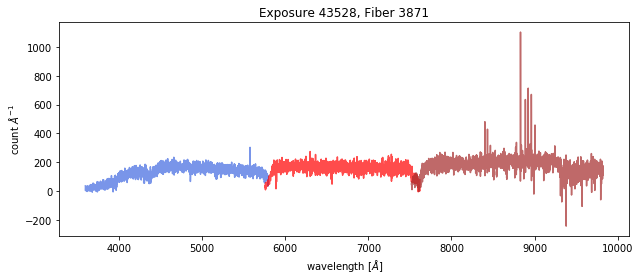

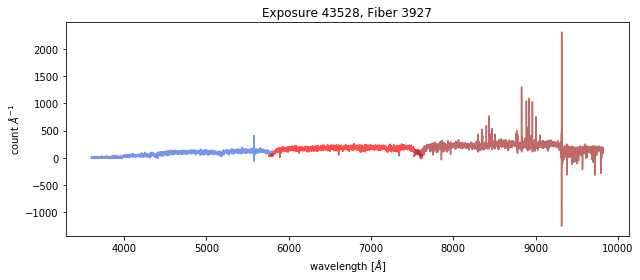

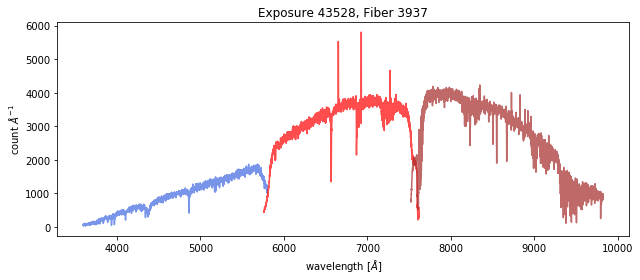

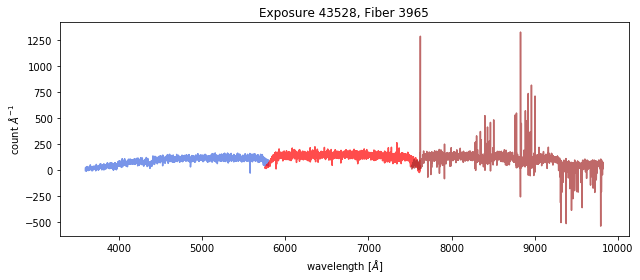

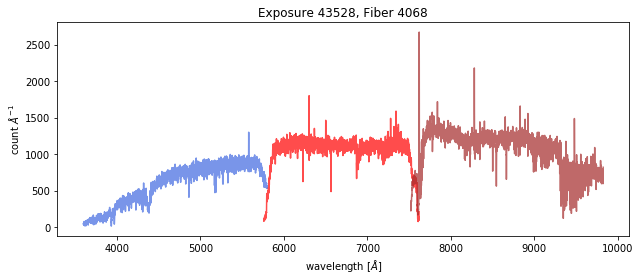

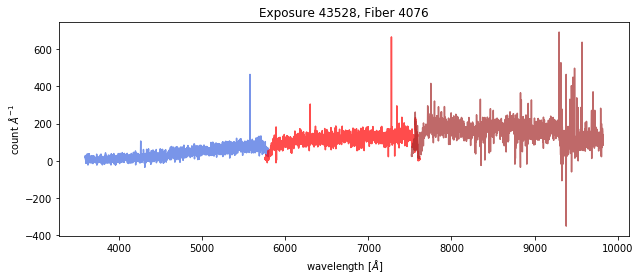

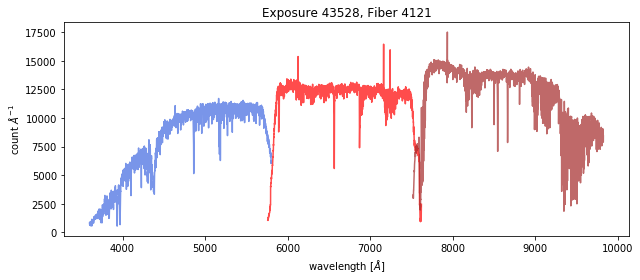

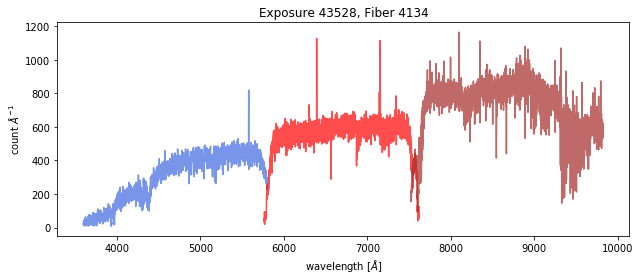

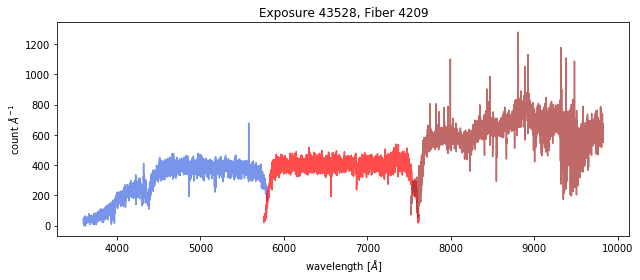

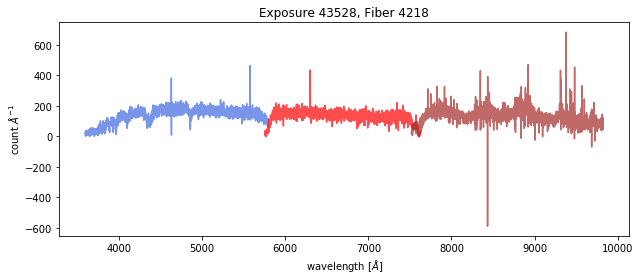

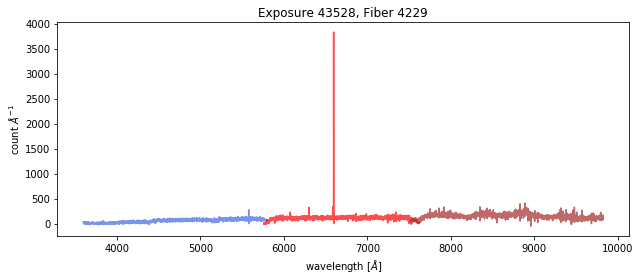

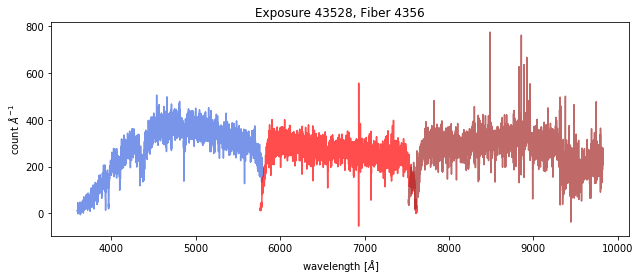

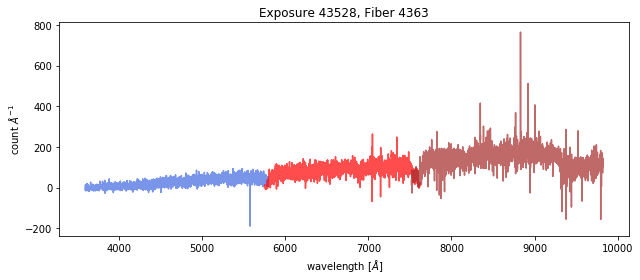

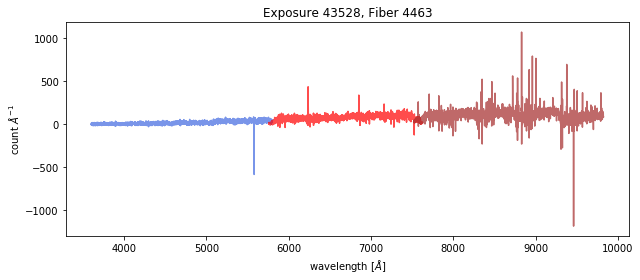

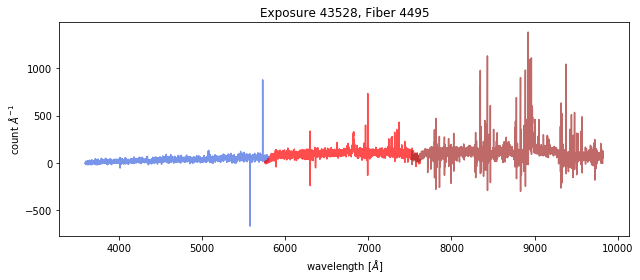

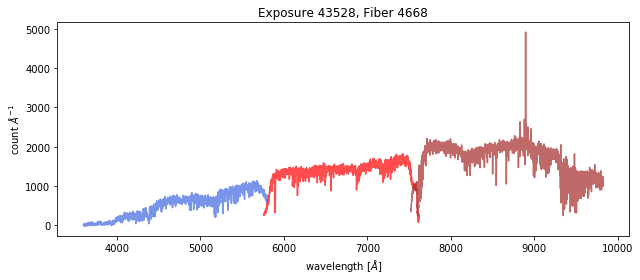

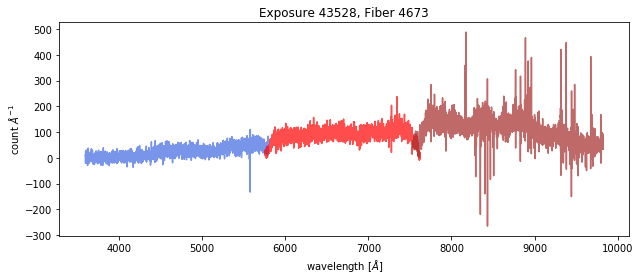

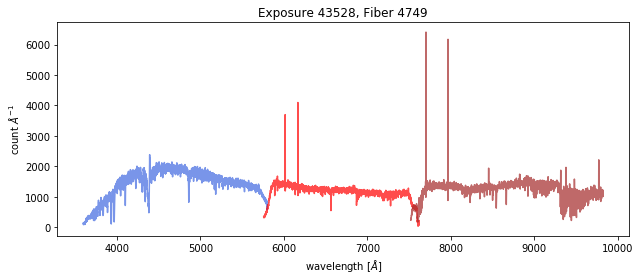

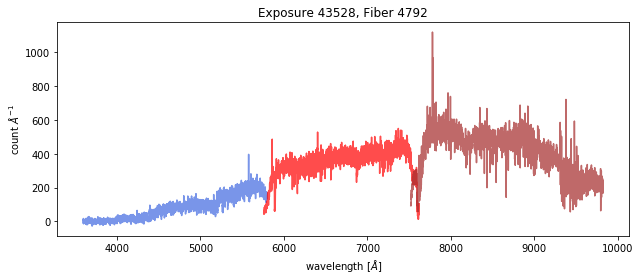

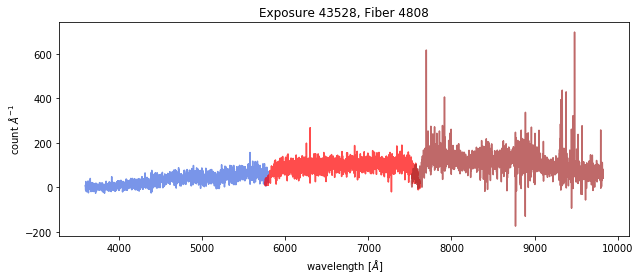

In [11]:
if len(data) > 0:
    n, fig = plot_lit_fibers(data, minsnr=5)
    print(n)
    plot_lit_spectra(data, minsnr=5.)